In [1]:
import numpy as np
import scipy as sp

from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
import sys
sys.path.append('./r_functions')
from python_wrappers import rtmvnorm, pmvnorm, mtmvnorm, moments_from_samples

R[write to console]: 载入需要的程辑包：mvtnorm

R[write to console]: 载入需要的程辑包：Matrix

R[write to console]: 载入需要的程辑包：stats4

R[write to console]: 载入需要的程辑包：gmm

R[write to console]: 载入需要的程辑包：sandwich

R[write to console]: 
载入程辑包：‘TruncatedNormal’


R[write to console]: The following objects are masked from ‘package:tmvtnorm’:

    dtmvnorm, dtmvt, ptmvnorm, ptmvt, rtmvnorm, rtmvt


R[write to console]: The following objects are masked from ‘package:mvtnorm’:

    pmvnorm, pmvt




Running R from rpy2: R version 3.6.3 (2020-02-29)


In [2]:
def fun(x):
    return (np.arctan(20*x - 10) - np.arctan(-10))/3

In [3]:
rbf = RBF(0.1)
x_train = (np.array([1/(n+2) for n in range(7)] ) + 0.1) .reshape(-1,1)
y_train = fun(x_train)
x_test = np.linspace(0, 1, 100).reshape(-1,1)

# 1.naive GPR

In [4]:
alpha = 1e-6
y_mean = y_train.mean()
y_train_ = y_train - y_mean
k_xx = rbf(x_train, x_train)
k_xx_inv = sp.linalg.inv(k_xx + alpha * np.eye(7) )
y_pred_naive = rbf(x_test, x_train).dot(k_xx_inv).dot(y_train_) + y_mean
y_std_naive = (rbf(x_test, x_test) - rbf(x_test, x_train).dot(k_xx_inv).dot(rbf(x_train, x_test))).diagonal()

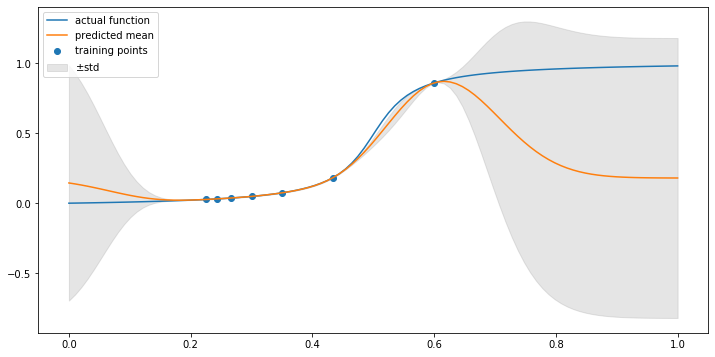

In [5]:
plt.figure(figsize=(12,6))
plt.scatter(x_train, y_train, label='training points')
plt.plot(x_test, fun(x_test), label='actual function')
plt.plot(x_test, y_pred_naive, label='predicted mean')
plt.fill_between(x_test.reshape(-1), (y_pred_naive.reshape(-1)+y_std_naive), (y_pred_naive.reshape(-1)-y_std_naive), label='$\pm$std', color='grey', alpha=0.2)
plt.legend()

# 2.constrained GPR

## 2.1 double side boundness projection

In [6]:
def boundness_proj(mean, std, x):
    upper_bound = upper_bound_func(x)
    lower_bound = lower_bound_func(x)
    pdf, cdf = sp.stats.norm.pdf, sp.stats.norm.cdf
    Z = cdf(upper_bound, mean, std) - cdf(lower_bound, mean, std)
    alpha = (lower_bound - mean)/std
    beta = (upper_bound - mean)/std
    mean_proj = Z * mean + (pdf(alpha) - pdf(beta))*std + lower_bound * cdf(alpha) + upper_bound * (1-cdf(beta))
    std_proj = Z * (mean**2+std**2) + 2 * mean * std * (pdf(alpha) - pdf(beta)) + std**2*(alpha*pdf(alpha)-beta*pdf(beta)) + lower_bound**2*cdf(alpha) + upper_bound**2*(1-cdf(beta)) - mean_proj**2
    return mean_proj, std_proj

In [7]:
lower_bound_func = lambda x: np.zeros(x.shape)
upper_bound_func = lambda x: np.log(30*x + 1)/3 + 0.1
y_bounded = np.array([boundness_proj(y_pred_naive[i], y_std_naive[i], x_test[i]) for i in range(len(y_pred_naive))])

y_pred_bounded = y_bounded[:,0]
y_std_bounded = y_bounded[:,1]

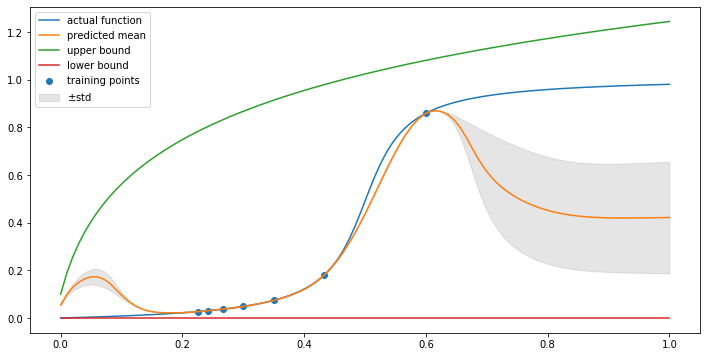

In [8]:
plt.figure(figsize=(12,6))
plt.scatter(x_train, y_train, label='training points')
plt.plot(x_test, fun(x_test), label='actual function')
plt.plot(x_test, y_pred_bounded, label='predicted mean')
plt.fill_between(x_test.reshape(-1), (y_pred_bounded.reshape(-1)+y_std_bounded.reshape(-1)), (y_pred_bounded.reshape(-1)-y_std_bounded.reshape(-1)), label='$\pm$std', color='grey', alpha=0.2)
plt.plot(x_test, upper_bound_func(x_test), label='upper bound')
plt.plot(x_test, lower_bound_func(x_test), label='lower bound')
plt.legend()

## 2.2 double side boundness with linear inequality method 

In [9]:
# find Xv with uniform samples
x_v = np.array([0.05*n for n in range(16)]).reshape(-1,1)
#x_v = np.array([[0.00100083], [0.89751217],[0.05563022],[0.75454877],[0.99999907],[0.67224169],[0.15122861],[0.82211359],[0.9463011 ],[0.5553775 ],[0.7185472 ],[0.03217454],[0.85708294],
#       [0.79532714],[0.91733144],[0.11541141],[0.65285475]]).reshape(-1, 1)
# compute all necessary variables 
sol_tri = sp.linalg.solve_triangular
y_train_ = y_train - y_mean

k_xx = rbf(x_train, x_train) + alpha * np.eye(len(x_train))
k_xv = rbf(x_train, x_v)
k_xs = rbf(x_train, x_test)
k_ss = rbf(x_test, x_test)
k_sv = rbf(x_test, x_v)
k_vv = rbf(x_v, x_v)
k_xx_inv = sp.linalg.inv(k_xx)

L = np.linalg.cholesky(k_xx) # lower triangle mat of cholesky decomposition
v2 = sol_tri(L, k_xs, lower=True)
A2 = sol_tri(L.T, v2).T
B2 = k_ss - v2.T.dot(v2)

v1 = sol_tri(L, k_xv, lower=True)
A1 = sol_tri(L.T, v1).T
B3 = k_sv - v2.T.dot(v1)
B1 = k_vv + alpha*np.eye(len(x_v)) - v1.T.dot(v1)

L1 = np.linalg.cholesky(B1)
v3 = sol_tri(L1, B3.T, lower=True)
A = sol_tri(L1.T, v3).T
B = A2 - A.dot(A1)
Sigma = B2 - v3.T.dot(v3)

In [10]:
# compute constrained distribution C
C_mean = A1.dot(y_train_)

# sample C of dim=[v, n_samples]
sample_size = 500
mulnorm = sp.stats.multivariate_normal
samples = []
Lb, Ub = lower_bound_func(x_v).reshape(-1) - y_mean, upper_bound_func(x_v).reshape(-1) - y_mean
#while len(samples) < sample_size:
#    new_sample = mulnorm(C_mean.reshape(-1), B1).rvs()
#    if np.all(new_sample > Lb) and np.all(new_sample < Ub):
#        samples.append(new_sample)
#C_samples = np.array(samples).T
C_samples = rtmvnorm(n=sample_size, mu=np.matrix(C_mean), sigma=np.matrix(B1), a=Lb, b=Ub, algorithm='minimax_tilting').T

# sample normal distribution from f*|Y,C
Sigma += alpha * np.eye(len(Sigma)) # stable numerial issue
normal_sample =  mulnorm(np.zeros(len(Sigma)), cov=Sigma).rvs(size=sample_size)
fs_sample = normal_sample.T

y_sample = A.dot(C_samples) + B.dot(y_train_) + fs_sample + y_mean

y_mean_constr = y_sample.mean(axis=1) 
y_std_constr = y_sample.std(axis=1) 

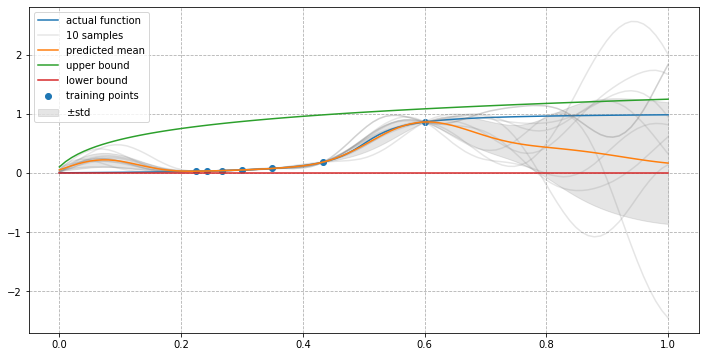

In [11]:
plt.figure(figsize=(12,6))
plt.scatter(x_train, y_train, label='training points')
plt.plot(x_test, fun(x_test), label='actual function')
plt.plot(x_test, y_sample[:,1:10], color='gray', alpha=0.2)
plt.plot(x_test, y_sample[:,1], color='gray', alpha=0.2, label='10 samples')
plt.plot(x_test, y_mean_constr, label='predicted mean')
plt.fill_between(x_test.reshape(-1), (y_mean_constr.reshape(-1)+y_std_constr.reshape(-1)), (y_mean_constr.reshape(-1)-y_std_constr.reshape(-1)), label='$\pm$std', color='grey', alpha=0.2)
plt.plot(x_test, upper_bound_func(x_test), label='upper bound')
plt.plot(x_test, lower_bound_func(x_test), label='lower bound')
plt.grid(ls='--')
plt.legend()

## 2.3 monotinic GPR with linear inequality method 

In [12]:
class dRBF(RBF):
    def dK(self, x1, x2):
        ''' return dK/dx1 '''
        amend_term = (x1.repeat(len(x2),axis=1) - x2.T) * (-1) / (self.length_scale**2)
        return self(x1, x2) * amend_term
    def LK(self, x1, x2, right=True, both_constraint=False):
        if right:
            dK = self.dK(x2, x1).T
            if both_constraint: # return row vector [KL.T K] 
                return np.block([dK, self(x1, x2)])
        else:
            dK = self.dK(x1, x2)
            if both_constraint: # returnr col vector [KL.T K].T
                return np.block([[dK],[self(x1, x2)]])
        return dK
    def LKL(self, x, both_constraint=False):
        ''' calculate L*K*LT'''
        if not both_constraint:
            amend_term = (1 - 1 / (self.length_scale**2) * (x - x.T)**2 ) 
            return amend_term * self(x, x) / (self.length_scale**2)
        else: # return  [ d^2K/dx1dx2 dK/dx2 
              #              dK/dx1     I    ]
            lt = self.LKL(x)
            rb = self(x)
            rt = self.LK(x, x, right=True)
            lb = self.LK(x, x)
            return np.block([[lt, rt], [lb, rb]])            
drbf = dRBF(0.1)

In [13]:
x_a = np.array([0.05*(n+1) for n in range(2)]).reshape(-1,1)
drbf.LKL(x_a, both_constraint=True)

array([[100.        ,  66.18726769,  -0.        ,  -4.41248451],
       [ 66.18726769, 100.        ,   4.41248451,  -0.        ],
       [ -0.        ,  -4.41248451,   1.        ,   0.8824969 ],
       [  4.41248451,  -0.        ,   0.8824969 ,   1.        ]])

In [14]:
lb_derivative = lambda x: np.zeros(x.shape)
ub_derivative = lambda x: np.full(x.shape, np.inf)

In [15]:
# find Xv with uniform samples
x_v = np.array([0.05*n for n in range(16)]).reshape(-1,1)
#x_v = np.array([[0.00100083], [0.89751217],[0.05563022],[0.75454877],[0.99999907],[0.67224169],[0.15122861],[0.82211359],[0.9463011 ],[0.5553775 ],[0.7185472 ],[0.03217454],[0.85708294],
#       [0.79532714],[0.91733144],[0.11541141],[0.65285475]]).reshape(-1, 1)
# compute all necessary variables 
sol_tri = sp.linalg.solve_triangular
y_train_ = y_train - y_mean

k_xx = drbf(x_train, x_train) + alpha * np.eye(len(x_train))
k_xv = drbf(x_train, x_v)
k_xs = drbf(x_train, x_test)
k_ss = drbf(x_test, x_test)
k_sv = drbf(x_test, x_v)
k_vv = drbf(x_v, x_v)
k_xx_inv = sp.linalg.inv(k_xx)

L = np.linalg.cholesky(k_xx) # lower triangle mat of cholesky decomposition
v2 = sol_tri(L, k_xs, lower=True)
A2 = sol_tri(L.T, v2).T
B2 = k_ss - v2.T.dot(v2)

v1 = sol_tri(L, drbf.LK(x_train, x_v), lower=True)
A1 = sol_tri(L.T, v1).T
B3 = drbf.LK(x_test, x_v) - v2.T.dot(v1)
B1 = drbf.LKL(x_v) + alpha*np.eye(len(x_v)) - v1.T.dot(v1)

L1 = np.linalg.cholesky(B1)
v3 = sol_tri(L1, B3.T, lower=True)
A = sol_tri(L1.T, v3).T
B = A2 - A.dot(A1)
Sigma = B2 - v3.T.dot(v3)

In [16]:
# compute constrained distribution C
C_mean = A1.dot(y_train)

# sample C of dim=[v, n_samples]
sample_size = 500
mulnorm = sp.stats.multivariate_normal
samples = []
Lb, Ub = lb_derivative(x_v).reshape(-1), ub_derivative(x_v).reshape(-1)
#while len(samples) < sample_size:
#    new_sample = mulnorm(C_mean.reshape(-1), B1).rvs()
#    if np.all(new_sample > Lb) and np.all(new_sample < Ub):
#        samples.append(new_sample)
#C_samples = np.array(samples).T
C_samples = rtmvnorm(n=sample_size, mu=np.matrix(C_mean), sigma=np.matrix(B1), a=Lb, b=Ub, algorithm='minimax_tilting').T

# sample normal distribution from f*|Y,C
Sigma += alpha * np.eye(len(Sigma)) # stable numerial issue
normal_sample =  mulnorm(np.zeros(len(Sigma)), cov=Sigma).rvs(size=sample_size)
fs_sample = normal_sample.T

y_sample = A.dot(C_samples) + B.dot(y_train) + fs_sample

y_std_constr = y_sample.std(axis=1) 
y_mean_constr = y_sample.mean(axis=1) 

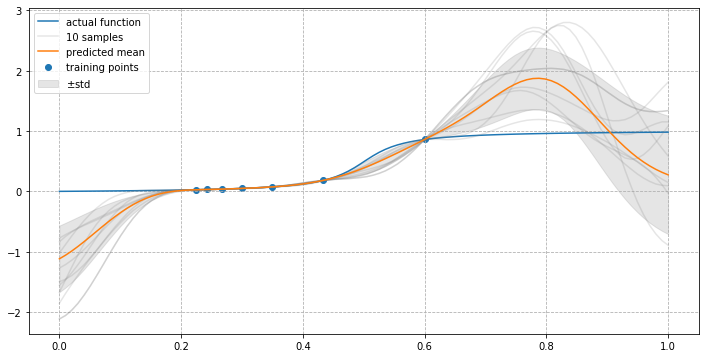

In [17]:
plt.figure(figsize=(12,6))
plt.scatter(x_train, y_train, label='training points')
plt.plot(x_test, fun(x_test), label='actual function')
plt.plot(x_test, y_sample[:,1:10], color='gray', alpha=0.2)
plt.plot(x_test, y_sample[:,1], color='gray', alpha=0.2, label='10 samples')
plt.plot(x_test, y_mean_constr, label='predicted mean')
plt.fill_between(x_test.reshape(-1), (y_mean_constr.reshape(-1)+y_std_constr.reshape(-1)), (y_mean_constr.reshape(-1)-y_std_constr.reshape(-1)), label='$\pm$std', color='grey', alpha=0.2)
#plt.fill_between(x_test.reshape(-1), (y_pred_bounded.reshape(-1)+y_std_bounded.reshape(-1)), (y_pred_bounded.reshape(-1)-y_std_bounded.reshape(-1)), label='$\pm$std', color='grey', alpha=0.2)
plt.grid(ls='--')
#plt.ylim([-0.1,1])
plt.legend()

drbf.LK(x_a, x_b, right=True, T=True)

## 2.4 monotonic + boundeness

In [18]:
# find Xv with uniform samples
x_v = np.array([0.05*n for n in range(16)]).reshape(-1,1)

#x_v = np.array([[0.00100083], [0.89751217],[0.05563022],[0.75454877],[0.99999907],[0.67224169],[0.15122861],[0.82211359],[0.9463011 ],[0.5553775 ],[0.7185472 ],[0.03217454],[0.85708294],
#       [0.79532714],[0.91733144],[0.11541141],[0.65285475]]).reshape(-1, 1)
# compute all necessary variables 
sol_tri = sp.linalg.solve_triangular
y_train_ = y_train - y_mean

k_xx = drbf(x_train, x_train) + alpha * np.eye(len(x_train))
k_xv = drbf(x_train, x_v)
k_xs = drbf(x_train, x_test)
k_ss = drbf(x_test, x_test)
k_sv = drbf(x_test, x_v)
k_vv = drbf(x_v, x_v)
k_xx_inv = sp.linalg.inv(k_xx)

L = np.linalg.cholesky(k_xx) # lower triangle mat of cholesky decomposition
v2 = sol_tri(L, k_xs, lower=True)
A2 = sol_tri(L.T, v2).T
B2 = k_ss - v2.T.dot(v2)

v1 = sol_tri(L, drbf.LK(x_train, x_v, both_constraint=True), lower=True)
A1 = sol_tri(L.T, v1).T
B3 = drbf.LK(x_test, x_v, both_constraint=True) - v2.T.dot(v1)
B1 = drbf.LKL(x_v, both_constraint=True) + alpha*np.eye(len(x_v) * 2) - v1.T.dot(v1)

L1 = np.linalg.cholesky(B1)
v3 = sol_tri(L1, B3.T, lower=True)
A = sol_tri(L1.T, v3).T
B = A2 - A.dot(A1)
Sigma = B2 - v3.T.dot(v3)

In [19]:
# compute constrained distribution C
C_mean = A1.dot(y_train)

# sample C of dim=[v, n_samples]
sample_size = 500
mulnorm = sp.stats.multivariate_normal
samples = []
Lb, Ub = np.r_[lb_derivative(x_v),lower_bound_func(x_v)].reshape(-1), np.r_[ub_derivative(x_v), upper_bound_func(x_v)].reshape(-1)
#while len(samples) < sample_size:
#    new_sample = mulnorm(C_mean.reshape(-1), B1).rvs()
#    if np.all(new_sample > Lb) and np.all(new_sample < Ub):
#        samples.append(new_sample)
#C_samples = np.array(samples).T


In [20]:
C_samples = rtmvnorm(n=sample_size, mu=np.matrix(C_mean), sigma=np.matrix(L1.dot(L1.T)), a=Lb, b=Ub, algorithm='minimax_tilting').T

# sample normal distribution from f*|Y,C
Sigma += alpha * np.eye(len(Sigma)) # stable numerial issue
normal_sample =  mulnorm(np.zeros(len(Sigma)), cov=Sigma).rvs(size=sample_size)
fs_sample = normal_sample.T

y_sample = A.dot(C_samples) + B.dot(y_train) + fs_sample

y_std_constr = y_sample.std(axis=1) 
y_mean_constr = y_sample.mean(axis=1) 

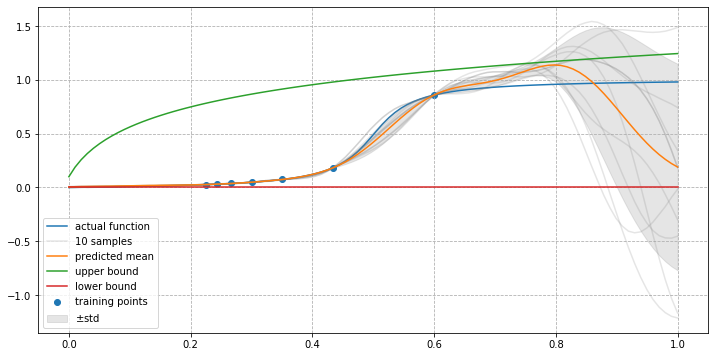

In [21]:
plt.figure(figsize=(12,6))
plt.scatter(x_train, y_train, label='training points')
plt.plot(x_test, fun(x_test), label='actual function')
plt.plot(x_test, y_sample[:,1:10], color='gray', alpha=0.2)
plt.plot(x_test, y_sample[:,1], color='gray', alpha=0.2, label='10 samples')
plt.plot(x_test, y_mean_constr, label='predicted mean')
#plt.fill_between(x_test.reshape(-1), (y_pred_bounded.reshape(-1)+y_std_bounded.reshape(-1)), (y_pred_bounded.reshape(-1)-y_std_bounded.reshape(-1)), label='$\pm$std', color='grey', alpha=0.2)
plt.fill_between(x_test.reshape(-1), (y_mean_constr.reshape(-1)+y_std_constr.reshape(-1)), (y_mean_constr.reshape(-1)-y_std_constr.reshape(-1)), label='$\pm$std', color='grey', alpha=0.2)
plt.plot(x_test, upper_bound_func(x_test), label='upper bound')
plt.plot(x_test, lower_bound_func(x_test), label='lower bound')
plt.grid(ls='--')
#plt.ylim([-0.1,1])
plt.legend()